In [11]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Поиск объекта на сцене с помощью гомографии
# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

# Используем SIFT и FLANN для сопоставления.
img_object = cv.imread('../lab1/test.jpg', cv.IMREAD_GRAYSCALE)
# img_scene = cv.imread('../lab1/test.jpg', cv.IMREAD_GRAYSCALE)
# img_scene = cv.imread('../lab3/img2.jpg', cv.IMREAD_GRAYSCALE)
img_scene = cv.imread('../lab3/images/3.jpg', cv.IMREAD_GRAYSCALE)
assert img_object is not None, "Файл не найден."
assert img_scene is not None, "Файл не найден."

In [12]:
# 2. Инициализируем SIFT
sift = cv.SIFT_create()

# 3. Находим ключевые точки и дескрипторы
kp1, des1 = sift.detectAndCompute(img_object, None)
kp2, des2 = sift.detectAndCompute(img_scene, None)

print("Ключевых точек в объекте:", len(kp1))
print("Ключевых точек в сцене:", len(kp2))

# 4. Настройка FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)

# 5. Сопоставление дескрипторов методом k-NN
matches = flann.knnMatch(des1, des2, k=2)

Ключевых точек в объекте: 1174
Ключевых точек в сцене: 714


In [13]:
# 6. Применяем тест Лоу (ratio test) для выбора "хороших" совпадений
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

print("Хороших совпадений:", len(good))

MIN_MATCH_COUNT = 10

if len(good) >= MIN_MATCH_COUNT:
    # 7. Строим гомографию по хорошим совпадениям
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # 8. Рисуем прямоугольник вокруг объекта на изображении сцены
    h, w = img_object.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)

    img_scene_color = cv.cvtColor(img_scene, cv.COLOR_GRAY2BGR)
    img_scene_color = cv.polylines(img_scene_color, [np.int32(dst)], True, (0, 255, 0), 3, cv.LINE_AA)
else:
    print(f"Недостаточно совпадений: {len(good)} / {MIN_MATCH_COUNT}")
    matches_mask = None
    img_scene_color = cv.cvtColor(img_scene, cv.COLOR_GRAY2BGR)

Хороших совпадений: 25


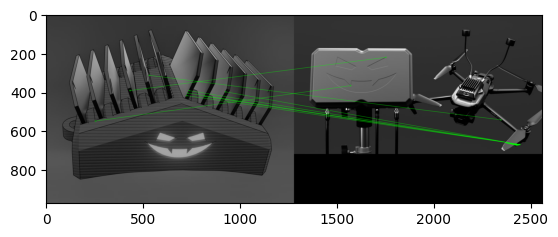

In [14]:
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=None,
    matchesMask=matches_mask,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

img_matches = cv.drawMatches(
    img_object, kp1,
    img_scene_color, kp2,
    good, None, **draw_params
)

plt.imshow(img_matches)